In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
import torchmetrics

In [2]:
print(torch.__version__)

2.4.1+cu121


In [3]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Get Data

In [4]:
import requests
import zipfile
from pathlib import Path

data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} directory already exists... skipping download.")
else :
    print(f"{image_path} directory doesn't exist, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", "wb") as file:
    request = requests.get('https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip')
    print("Downloading pizza, sushi and steak data....")
    file.write(request.content)

with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    zip_ref.extractall(image_path)
    print("Done")

data/pizza_steak_sushi directory doesn't exist, creating one...
Done


# Becoming one with the data (preparation and exploration)

In [5]:
import os
def walk_through_dir(dir_path):
    '''Walks through dir and returns the content in it.'''
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath} filepath.")

In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in data/pizza_steak_sushi filepath.
There are 3 directories and 0 images in data/pizza_steak_sushi/test filepath.
There are 0 directories and 25 images in data/pizza_steak_sushi/test/pizza filepath.
There are 0 directories and 19 images in data/pizza_steak_sushi/test/steak filepath.
There are 0 directories and 31 images in data/pizza_steak_sushi/test/sushi filepath.
There are 3 directories and 0 images in data/pizza_steak_sushi/train filepath.
There are 0 directories and 78 images in data/pizza_steak_sushi/train/pizza filepath.
There are 0 directories and 75 images in data/pizza_steak_sushi/train/steak filepath.
There are 0 directories and 72 images in data/pizza_steak_sushi/train/sushi filepath.


In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random Image Path : data/pizza_steak_sushi/train/pizza/3269634.jpg
Image class : pizza
Image height and width : 512 x 512


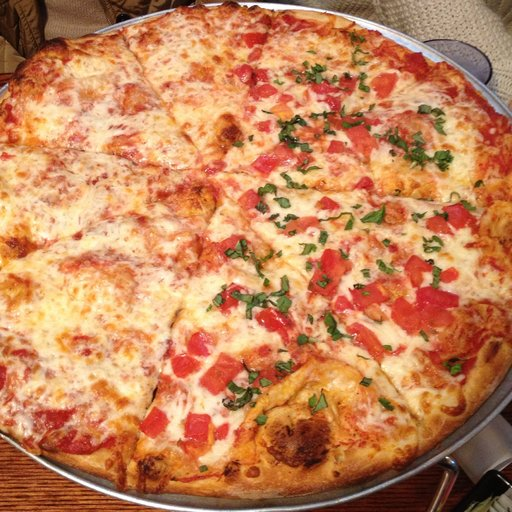

In [8]:
import random
from PIL import Image

image_path_list = list(image_path.glob('*/*/*.jpg'))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random Image Path : {random_image_path}")
print(f"Image class : {image_class}")
print(f"Image height and width : {img.height} x {img.width}")
img

In [9]:
np.asarray(img).shape

(512, 512, 3)

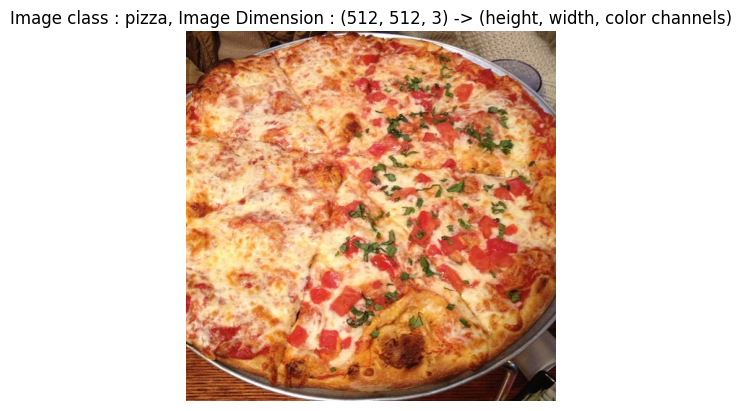

In [10]:
plt.imshow(np.asarray(img))
plt.title(f"Image class : {image_class}, Image Dimension : {np.asarray(img).shape} -> (height, width, color channels)")
plt.axis(False);

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [12]:
type(img)

PIL.JpegImagePlugin.JpegImageFile

In [13]:
im = (transforms.Resize(size=(64, 64))(img))
im = transforms.RandomHorizontalFlip(p=0.5)(im)
print(transforms.ToTensor()(im).shape)
print(np.asarray(im).shape)
print(transforms.ToTensor()(np.asarray(im)).shape)

torch.Size([3, 64, 64])
(64, 64, 3)
torch.Size([3, 64, 64])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


## PyPlot's default dimension expectations are (height, width, color channels) and PyTorch's expectations are (color channels, height, width).
## Thus, .permute() helps here

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [15]:
# Using transforms to transform our image
data_transform = transforms.Compose([
    # Resize
    transforms.Resize(size=(64, 64)),
    # Flip randomly
    transforms.RandomHorizontalFlip(p=0.5),
    # Image to Tensor
    transforms.ToTensor()
])

In [16]:
data_transform(img).shape

torch.Size([3, 64, 64])

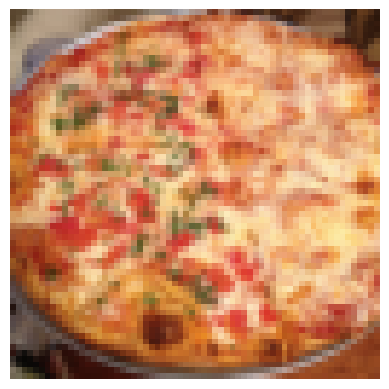

In [17]:
plt.imshow(data_transform(img).permute(1, 2, 0))
plt.axis('off');

# Option 1 : Loading image data using `torchvision.datasets.ImageFolder` (for this speciic directory architechure)

In [18]:
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, 
                                  transform=data_transform,
                                  target_transform=None)

test_data = datasets.ImageFolder(root=test_dir)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test)

In [19]:
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [20]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [21]:
len(train_data), len(test_data)

(225, 75)

In [22]:
train_data.samples[75:85], train_data.targets[75:85]

([('data/pizza_steak_sushi/train/pizza/786995.jpg', 0),
  ('data/pizza_steak_sushi/train/pizza/853441.jpg', 0),
  ('data/pizza_steak_sushi/train/pizza/928670.jpg', 0),
  ('data/pizza_steak_sushi/train/steak/100135.jpg', 1),
  ('data/pizza_steak_sushi/train/steak/1225762.jpg', 1),
  ('data/pizza_steak_sushi/train/steak/1257104.jpg', 1),
  ('data/pizza_steak_sushi/train/steak/1264154.jpg', 1),
  ('data/pizza_steak_sushi/train/steak/1382427.jpg', 1),
  ('data/pizza_steak_sushi/train/steak/1413972.jpg', 1),
  ('data/pizza_steak_sushi/train/steak/1598345.jpg', 1)],
 [0, 0, 0, 1, 1, 1, 1, 1, 1, 1])

In [23]:
train_data[0][0].shape, train_data[0][1]

(torch.Size([3, 64, 64]), 0)

torch.Size([3, 64, 64]) 0 pizza


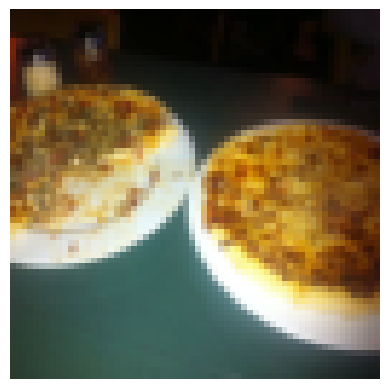

In [24]:
image, label = train_data[0][0], train_data[0][1]
print(image.shape, label, class_names[label])

plt.imshow(image.permute(1, 2, 0))
plt.axis('off');

In [25]:
import os
os.cpu_count()

4

In [26]:
from torch.utils.data import DataLoader
import os

train_dataloader = DataLoader(dataset=train_data, batch_size=4, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(dataset=test_data, batch_size=4, shuffle=False, num_workers=os.cpu_count())

In [27]:
len(train_dataloader), len(test_dataloader)

(57, 19)

In [28]:
img, label = next(iter(train_dataloader))
print(f"Image shape : {img.shape} ==> (batch_size, color_channels, height, width)")
print(f"Label shape : {label.shape}, Real Labels : {label}")

Image shape : torch.Size([4, 3, 64, 64]) ==> (batch_size, color_channels, height, width)
Label shape : torch.Size([4]), Real Labels : tensor([1, 1, 0, 1])


# Option 2 : Loading Image Data with a Custom Dataset

In [29]:
import os
from pathlib import Path
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, List, Dict

In [30]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [31]:
obj = os.scandir(train_dir)
for i in obj:
    print(i.name)

pizza
steak
sushi


In [32]:
# Lets replicate the above function
target_directory = train_dir
print(f"Target Directory Path : {target_directory}")

class_names_found = sorted([entry.name for entry in os.scandir(target_directory)])
class_names_found

Target Directory Path : data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [33]:
# Lets functionize this
def find_classes(target_directory):
    '''Finds the class folder names in the target directory.'''
    classes = sorted([entry.name for entry in os.scandir(target_directory)])

    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {target_directory}....")

    class_to_idx = {class_name : i for i, class_name in enumerate(classes)}

    return classes, class_to_idx

In [34]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## Creating a Custom Dataset to replicate `ImageFolder`

In [35]:
(list(Path(target_directory).glob('*/*.jpg'))[224]) # Last image (225 is len)

PosixPath('data/pizza_steak_sushi/train/sushi/1221830.jpg')

In [36]:
list(Path(target_directory).glob('*/*.jpg'))[224].parent.name

'sushi'

In [37]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
    def __init__(self, targ_dir:str, transform=None):
        self.paths = list(Path(targ_dir).glob('*/*.jpg'))
        self.classes, self.class_to_idx = find_classes(targ_dir)
        self.transform = transform


    def load_image(self, index:int) -> Image.Image:
        '''Opens an image via a path and returns it.'''
        image_path = self.paths[index]
        return Image.open(image_path)

    def __len__(self,) -> int:
        '''Returns the total number of samples.'''
        return len(self.paths)

    def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
        '''Returns one sample of data, data and label (X & y).'''
        image = self.load_image(index=index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]

        if self.transform :
            return self.transform(image), class_idx
        else :
            return image, class_idx

In [38]:
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [39]:
train_custom_data = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_custom_data = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)

In [40]:
train_custom_data, test_custom_data

(<__main__.ImageFolderCustom at 0x79300088eb90>,
 <__main__.ImageFolderCustom at 0x79300088d180>)

In [41]:
len(train_data), len(train_custom_data), len(test_data), len(test_custom_data)

(225, 225, 75, 75)

In [42]:
train_custom_data.classes

['pizza', 'steak', 'sushi']

In [43]:
train_custom_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [44]:
def display_random_images(dataset:torch.utils.data.Dataset,
                          classes:List[str]=None,
                          n:int=10,
                          display_shape:bool=False,
                          seed:int=None):
    if n>10:
        n=10
        display_shape=False
        print("For display purposes, n shouldn't be higher than 10. Thus, setting to 10 and removing shape.")

    if seed:
        random.seed(seed)

    random_sample_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 8))

    for i, targ_sample in enumerate(random_sample_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image.permute(1, 2, 0)) # Cuz plt expects h,w,c and torch is c,h,w
        plt.axis('off')
        if classes:
            title=f"Class : {classes[targ_label]}"
            if display_shape:
                title = title + f"\nShape : {targ_image.shape}(torch) and {targ_image.permute(1, 2, 0).shape}(plt)"
        plt.title(title)
        plt.show()

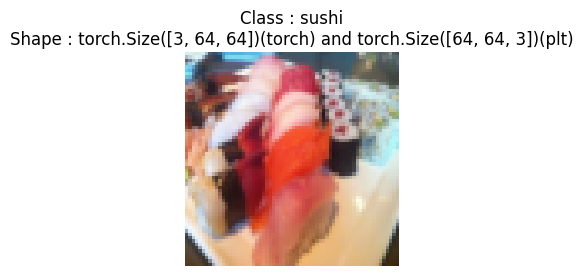

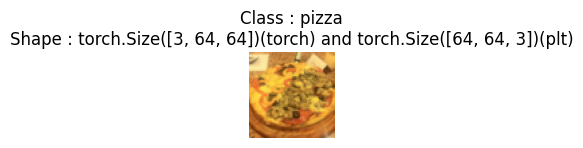

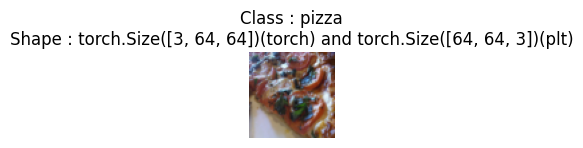

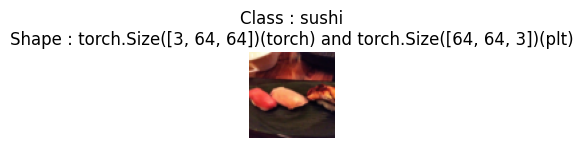

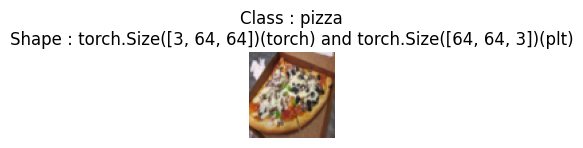

In [45]:
display_random_images(train_custom_data, train_custom_data.classes, 5, True, 42)

In [46]:
os.cpu_count()

4

In [47]:
from torch.utils.data import DataLoader

train_dataloader_custom = DataLoader(dataset=train_custom_data, batch_size=4, shuffle=True)
test_dataloader_custom = DataLoader(dataset=test_custom_data, batch_size=4, shuffle=False)

train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7930008c7910>,
 <torch.utils.data.dataloader.DataLoader at 0x7930008c74c0>)

In [48]:
len(train_dataloader_custom), len(test_dataloader_custom), 

(57, 19)

In [49]:
for image, label in train_dataloader_custom:
    print(image.shape, label)
    break

torch.Size([4, 3, 64, 64]) tensor([2, 1, 2, 1])


In [50]:
next(iter(train_dataloader))[0].shape

torch.Size([4, 3, 64, 64])

# Data Augmentation

In [51]:
# Already used in torchvision.transforms.Compose()
# Explore more in https://pytorch.org/vision/main/transforms.html
# Also research more on something called AutoAugmentation

# A good blogpost : https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/
# Actually, it's a perfect blogpost!!!!

In [52]:
# Lets look at one of the kind - TrivialAugment
from torchvision import transforms
train_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [53]:
image_path

PosixPath('data/pizza_steak_sushi')

In [54]:
image[0].shape

torch.Size([3, 64, 64])

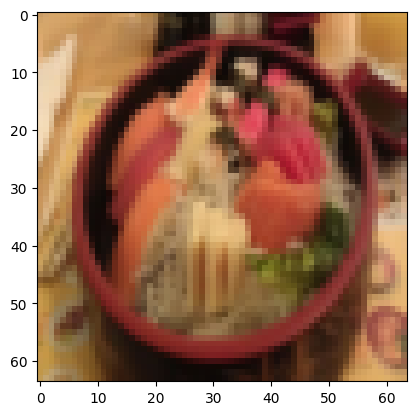

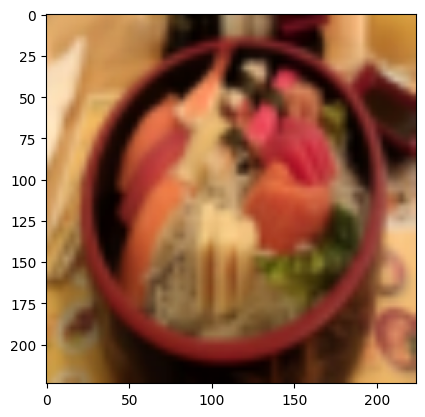

In [55]:
from torchvision.transforms import ToPILImage
img = ToPILImage()(image[0])
plt.imshow(image[0].permute(1, 2, 0))
plt.show()
plt.imshow(train_transforms(img).permute(1, 2, 0))
plt.show();

# Model 0 : TinyVGG without data augmentation

## Creating transforms and loading data for Model 0

In [56]:
simple_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir, 
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir, 
                                         transform=simple_transform)

import os
from torch.utils.data import Dataset, DataLoader

train_dataloader_simple = DataLoader(dataset=train_data_simple, batch_size=4, 
                                     num_workers=os.cpu_count(), shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple, batch_size=4, 
                                     num_workers=os.cpu_count(), shuffle=False)

In [57]:
import torch
from torch import nn, optim

class TinyVGG(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        # print(nn.Flatten()(x).shape)
        x = self.classifier(x)
        return x

In [58]:
model_0 = TinyVGG(input_shape=3, hidden_units=10, output_shape=3)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [59]:
dummy_image = torch.rand(size=(1, 3, 64, 64))
torch.argmax(torch.softmax(model_0(dummy_image), dim=1), dim=1)

tensor([2])

In [60]:
next(iter(train_dataloader_simple))[0].shape, next(iter(train_dataloader_simple))[1].shape

(torch.Size([4, 3, 64, 64]), torch.Size([4]))

In [61]:
import torchinfo
from torchinfo import summary

summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

In [62]:
def train_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer, device=device):
    model.train()

    train_loss = 0
    test_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred_argmax = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class==y).sum().item() / len(y)
    train_loss = train_loss / len(train_dataloader)
    train_acc = train_acc / len(train_dataloader)
    return train_loss, train_acc

In [63]:
def eval_step(model:torch.nn.Module, dataloader:torch.utils.data.DataLoader, 
               loss_fn:torch.nn.Module, optimizer:torch.optim.Optimizer, device=device):
    model.eval()
    with torch.inference_mode():
        test_loss = 0
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            y_pred_argmax = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (y_pred_class==y).sum().item() / len(y)
        test_loss = test_loss / len(dataloader)
        test_acc = test_acc / len(dataloader)
        return test_loss, test_acc

In [64]:
# Normal training loops ..... as discussed earlier.

Overfitting and Undrfitting, How to deal with it? Ideal Loss Curves?

https://www.learnpytorch.io/04_pytorch_custom_datasets/

# Comparing model results

1. Hard coding
2. PyTorch + TensorBoard
3. Weights and Biases (experiment tracking)
4. MLFlow

# Three most common errors in PyTorch : 
1. **Shape errors / mismatches** :  For example, your data's shape is [1, 28, 28] but your first layer takes an input of [10].
2. **Device errors** : For example your model is on the GPU (e.g. "cuda") and your data is on the CPU (e.g. "cpu").
3. **Datatype errors**: For example, your data is one datatype (e.g. torch.float32), however the operation you're trying to perform requires another datatype (e.g. torch.int64).

For everything, to learn : https://www.learnpytorch.io/